In [153]:
import pandas as pd
import os, string
import re
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer
import spacy
from spacy.tokenizer import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import text

import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

#### Read data

In [154]:
df = pd.read_json('reddit_jokes.json')

#### EDA

In [155]:
df.head()

,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”"
4,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...


In [156]:
df.describe()

,score
count,194553.000000
mean,118.223255
std,936.231277
min,0.000000
25%,0.000000
50%,3.000000
75%,16.000000
max,48526.000000


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194553 entries, 0 to 194552
Data columns (total 4 columns):
body     194553 non-null object
id       194553 non-null object
score    194553 non-null int64
title    194553 non-null object
dtypes: int64(1), object(3)
memory usage: 5.9+ MB


Distributions - Numerical features:

In [158]:
# Remove skew
def remove_skew_95(df,col,mean = None,std = None):
    if not mean:
        mean = df[col].mean()
    if not std:
        std = df[col].std()
    df = df[df[col] > (mean-2*std)]
    df = df[df[col] < (mean+2*std)]
    return df

In [159]:
df = remove_skew_95(df,'score')

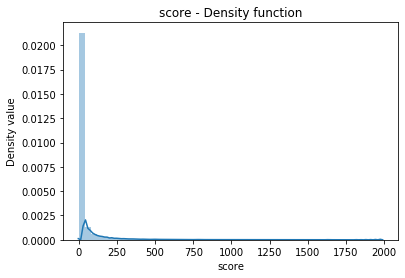

In [160]:
num_features = ['score']
for feat in num_features:
    ax = sns.distplot(df[df[feat].notna()][feat]);
    ax.set_title(f'{feat} - Density function');
    ax.set_ylabel('Density value');
    plt.show();

In [161]:
df = remove_skew_95(df,'score')

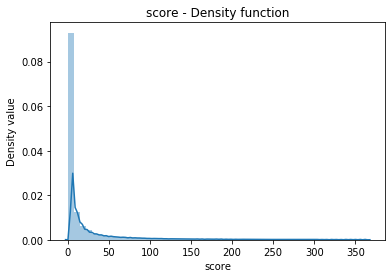

In [162]:
num_features = ['score']
for feat in num_features:
    ax = sns.distplot(df[df[feat].notna()][feat]);
    ax.set_title(f'{feat} - Density function');
    ax.set_ylabel('Density value');
    plt.show();

In [163]:
score_filtered = (df[df['score']> 0]['score']).reset_index()['score']

In [164]:
score_filtered

0           1
1           1
2           1
3          15
4           3
         ... 
125368    123
125369      5
125370     12
125371     44
125372     63
Name: score, Length: 125373, dtype: int64

In [165]:
df.describe()

,score
count,186934.000000
mean,20.158783
std,49.086623
min,0.000000
25%,0.000000
50%,2.000000
75%,13.000000
max,365.000000


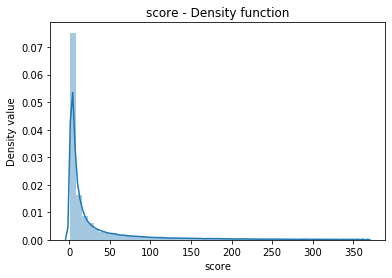

In [166]:
num_features = ['score']
for feat in num_features:
    ax = sns.distplot(score_filtered);
    ax.set_title(f'{feat} - Density function');
    ax.set_ylabel('Density value');
    plt.show();

In [167]:
df.body.apply(lambda x: len(x.split(' ')))

0          12
1          13
2          34
3          87
4          12
         ... 
194548     10
194549      5
194550      7
194551    104
194552      5
Name: body, Length: 186934, dtype: int64

In [168]:
df['body_len']= df.body.str.len()
df['title_len']= df.title.str.len()
df['total_len'] = df['body_len']+df['title_len']
df['body_words']= df.body.apply(lambda x: len(x.split(' ')))
df['title_words']= df.title.apply(lambda x: len(x.split(' ')))
df['total_words'] = df['body_words']+df['title_words']

In [169]:
pd.DataFrame(df['body_len'].describe())

,body_len
count,186934.000000
mean,196.922112
std,564.373112
min,0.000000
25%,22.000000
50%,43.000000
75%,133.000000
max,39728.000000


In [170]:
pd.DataFrame(df['title_len'].describe())

,title_len
count,186934.000000
mean,44.800630
std,23.157885
min,1.000000
25%,30.000000
50%,42.000000
75%,55.000000
max,300.000000


In [171]:
pd.DataFrame(df['total_len'].describe())

,total_len
count,186934.000000
mean,241.722742
std,562.651070
min,1.000000
25%,66.000000
50%,94.000000
75%,179.000000
max,39742.000000


In [172]:
pd.DataFrame(df['body_words'].describe())

,body_words
count,186934.000000
mean,36.283084
std,102.653563
min,1.000000
25%,4.000000
50%,8.000000
75%,24.000000
max,7408.000000


In [173]:
pd.DataFrame(df['title_words'].describe())

,title_words
count,186934.000000
mean,8.567794
std,4.440246
min,1.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,66.000000


In [174]:
pd.DataFrame(df['total_words'].describe())

,total_words
count,186934.000000
mean,44.850878
std,102.317362
min,2.000000
25%,13.000000
50%,18.000000
75%,33.000000
max,7411.000000


Relations with the dependent variable - Numerical features:

In [175]:
df.corr()

,score,body_len,title_len,total_len,body_words,title_words,total_words
score,1.000000,0.093032,0.002302,0.093411,0.093091,0.004474,0.093591
body_len,0.093032,1.000000,-0.094764,0.999160,0.990107,-0.096771,0.989160
title_len,0.002302,-0.094764,1.000000,-0.053895,-0.096619,0.959462,-0.055299
total_len,0.093411,0.999160,-0.053895,1.000000,0.989160,-0.057577,0.989912
body_words,0.093091,0.990107,-0.096619,0.989160,1.000000,-0.097220,0.999067
title_words,0.004474,-0.096771,0.959462,-0.057577,-0.097220,1.000000,-0.054143
total_words,0.093591,0.989160,-0.055299,0.989912,0.999067,-0.054143,1.000000


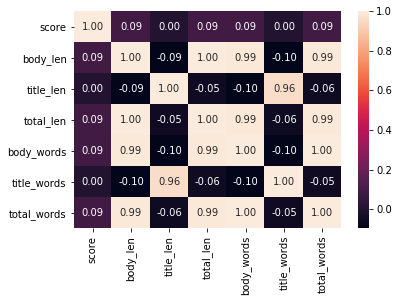

In [176]:
f = plt.figure();
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

#### Redundant features removal

In [177]:
df.shape

(186934, 10)

In [178]:
df = df[df.score > 0].reset_index()
df.shape

(125373, 11)

In [179]:
df = df[df.total_words > 5].reset_index()
df.shape

(124774, 12)

Create 'joke' column and remove unnecessary columns:

In [180]:
df

,level_0,index,body,id,score,title,body_len,title_len,total_len,body_words,title_words,total_words
0,0,0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore,57,48,105,12,10,22
1,1,3,A Sunday school teacher is concerned that his ...,5tz2wj,1,"Brian raises his hand and says, “He’s in Heaven.”",528,49,577,87,9,96
2,2,7,"Apparently ""Whatever's low in cholesterol"" was...",5tz04j,1,I walked into a PETA adoption center and the r...,68,92,160,10,18,28
3,3,10,"I always thought they were gunna hit me, not t...",5tyzxh,15,Remember when you were a kid and when you crie...,111,99,210,21,20,41
4,4,13,"I said, ""I'm not sure; it's hard to keep track.""",5tyytx,3,"My boss said to me, ""you're the worst train dr...",48,95,143,10,18,28
...,...,...,...,...,...,...,...,...,...,...,...,...
124769,125368,194547,"Just this morning she said, ""Daddy, is that th...",1a8a5r,123,My daughter has reached that age where she's a...,70,84,154,14,13,27
124770,125369,194548,Gives me something to read while i'm in the sh...,1a89ts,5,I like a girl with words tattooed on her back.,52,46,98,10,10,20
124771,125370,194549,I mean dyslexia fcuk!!! >_<,1a87we,12,I have sexdaily...,27,18,45,5,3,8
124772,125371,194550,A hockey player showers after three periods.,1a7xnd,44,What's the difference between a hippie chick a...,44,65,109,7,11,18


In [181]:
df['joke'] = df['title'] +'. '+ df['body']

In [182]:
df = df.loc[:,['joke','score']]

#### Pre-process text

Pre-process text:
- Remove punctuation
- Replace escape characters
- Remove extra spaces
- Remove single characters
- Remove prefixed 'b'
- Lowercase all characters
- Lemmatization

In [183]:
def replace_non_eng_punct(txt):
    return re.sub(r'/[^a-zA-Z0-9\s,.?!]/','*',txt).strip()

In [184]:
# def remove_url(txt):
#     return re.sub(r'https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}','',txt)

In [185]:
def replace_escape(txt):
    updated_txt = re.sub(r'\n|\t|&amp;',' ',txt)
    return updated_txt.strip()

In [186]:
def remove_multi_spaces(txt):
    return re.sub(' +', ' ',txt)

In [187]:
import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
#         # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

#         # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

#         # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [188]:
df['joke'] = df['joke'].apply(replace_non_eng_punct).apply(remove_multi_spaces)

In [189]:
df['joke_preprocessed'] = df['joke'].apply(preprocess_text)

Sample before/after preprocessing:

In [190]:
df['joke'][12]

'When You Break Up At 11:59 Tonight. And save $300 instantly.'

In [191]:
df['joke_preprocessed'][1]

'brian raise hand heaven sunday school teacher concerned student might little confused jesus asks class jesus today brian raise hand heaven susan answer heart little johnny wave hand furiously blurts bathroom teacher surprised answer asks little johnny know well little johnny every morning bang bathroom door yell jesus christ still'

Create joke tokens list:

In [192]:
def split_punct(txt):
    return re.split(r'(\W)',txt)

In [193]:
df['joke_tokens'] = df['joke_preprocessed'].apply(split_punct)

In [194]:
def remove_spaces(lst):
    return [x for x in lst if (x != ' ') and (x != '')]

In [195]:
df['joke_tokens'] = df['joke_tokens'].apply(remove_spaces)

#### Feature engineering

Train/test split:

In [196]:
target_col = 'score'
tokens_col = 'joke_preprocessed'
X = df[tokens_col].to_numpy()
y = df[target_col].to_numpy()

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=42)

Feature scaling:

In [198]:
scaler = StandardScaler()
scaler.fit(y_train.reshape(-1,1))
y_train = scaler.transform(y_train.reshape(-1,1)).reshape(-1,)
y_test = scaler.transform(y_test.reshape(-1,1)).reshape(-1,)

Generate vocabulary:

In [199]:
cnt2 = Counter()
for j in df['joke']:
    for w in j.split(' '):
        cnt2[w] += 1

In [200]:
(np.array(list(cnt.values()))>55).sum()

4944

In [201]:
print(f'Total amount of words before pre-processing: {sum(cnt2.values()):,}')
print(f'Total amount of words after pre-processing: {sum(cnt.values()):,}')
print(f'Vocabulary size before pre-processing: {len(cnt2.keys()):,}')
print(f'Vocabulary size after pre-processing: {len(cnt.keys()):,}')

Total amount of words before pre-processing: 6,217,991
Total amount of words after pre-processing: 2,586,238
Vocabulary size before pre-processing: 350,133
Vocabulary size after pre-processing: 53,170


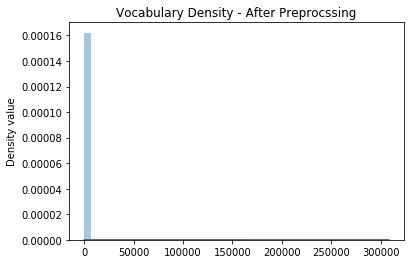

In [202]:

ax = sns.distplot(list(cnt2.values()));
ax.set_title(f'Vocabulary Density - After Preprocssing');
ax.set_ylabel('Density value');
plt.show();

In [203]:
len(cnt2.keys())

350133

In [204]:
len(cnt.keys())

53170

In [205]:
cnt = Counter()
for s in df['joke_tokens']:
    for w in s:
        cnt[w] += 1

In [206]:
vocab2 = cnt.most_common(5000)
vocab2 = [i[0] for i in vocab2]

Generate TFIDF/CountVectorizer features:

In [207]:
concat_filter_vec2 = np.vectorize(lambda x: ' '.join([i for i in x.split(' ') if i in vocab2]))

In [208]:
X_train.shape[0] + X_test.shape[0]

124774

In [209]:
X_train = concat_filter_vec2(X_train)
X_test = concat_filter_vec2(X_test)

In [210]:
X_train[6]

'planned year hearing thought'

In [234]:
X_test_count.shape

(24955, 4997)

In [216]:
vectorizer_tf = TfidfVectorizer()
X_train_tf = vectorizer_tf.fit_transform(X_train).toarray()
X_test_tf = vectorizer_tf.transform(X_test).toarray()

In [217]:
c = CountVectorizer()
X_train_count = c.fit_transform(X_train).toarray()
X_test_count = c.fit_transform(X_test).toarray()

In [270]:
b = np.zeros((X_test_count.shape[0],2))

In [271]:
X_test_count.shape

(24955, 4997)

In [272]:
b.shape

(24955, 2)

In [276]:
X_test_count = np.hstack((X_test_count,b))

In [218]:
X_test_count.shape

(24955, 4997)

In [219]:
X_train_count.shape

(99819, 4999)

In [120]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, LSTM, Embedding, TimeDistributed, recurrent
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from keras import regularizers

#### Modeling

Train Neural network

In [281]:
# Neural network
model = Sequential()
model.add(Dense(128, input_dim=4999, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1,kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

In [282]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               640000    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 673,153
Trainable params: 673,153
Non-trainable params: 0
_________________________________________________________________


In [283]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

In [284]:
model.fit(X_train_count, y_train, epochs=40, batch_size=200,validation_split = 0.2)

Train on 79855 samples, validate on 19964 samples
Epoch 1/40
79855/79855 [==============================] - 10s 129us/step - loss: 6.0338 - mean_squared_error: 1.0041 - val_loss: 5.3357 - val_mean_squared_error: 0.9838
Epoch 2/40
79855/79855 [==============================] - 8s 102us/step - loss: 5.0028 - mean_squared_error: 1.0041 - val_loss: 4.6553 - val_mean_squared_error: 0.9837
Epoch 3/40
79855/79855 [==============================] - 7s 90us/step - loss: 4.4030 - mean_squared_error: 1.0041 - val_loss: 4.1073 - val_mean_squared_error: 0.9837
Epoch 4/40
79855/79855 [==============================] - 8s 106us/step - loss: 3.9005 - mean_squared_error: 1.0044 - val_loss: 3.6585 - val_mean_squared_error: 0.9837
Epoch 5/40
79855/79855 [==============================] - 8s 96us/step - loss: 3.4734 - mean_squared_error: 1.0042 - val_loss: 3.2630 - val_mean_squared_error: 0.9838
Epoch 6/40
79855/79855 [==============================] - 7s 90us/step - loss: 3.1109 - mean_squared_error: 1.0

In [285]:
# Neural network
model_tf = Sequential()
model_tf.add(Dense(128, input_dim=4999, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model_tf.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model_tf.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model_tf.add(Dense(1,kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))

In [286]:
model_tf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               640000    
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 673,153
Trainable params: 673,153
Non-trainable params: 0
_________________________________________________________________


In [287]:
model_tf.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])

In [288]:
model_tf.fit(X_train_tf, y_train, epochs=40, batch_size=200,validation_split = 0.2)

Train on 79855 samples, validate on 19964 samples
Epoch 1/40
79855/79855 [==============================] - 13s 161us/step - loss: 5.7309 - mean_squared_error: 1.0043 - val_loss: 5.3165 - val_mean_squared_error: 0.9837
Epoch 2/40
79855/79855 [==============================] - 9s 118us/step - loss: 5.0173 - mean_squared_error: 1.0042 - val_loss: 4.6838 - val_mean_squared_error: 0.9838
Epoch 3/40
79855/79855 [==============================] - 7s 93us/step - loss: 4.4267 - mean_squared_error: 1.0041 - val_loss: 4.1257 - val_mean_squared_error: 0.9837
Epoch 4/40
79855/79855 [==============================] - 8s 94us/step - loss: 3.9237 - mean_squared_error: 1.0042 - val_loss: 3.6654 - val_mean_squared_error: 0.9837
Epoch 5/40
79855/79855 [==============================] - 8s 96us/step - loss: 3.4950 - mean_squared_error: 1.0042 - val_loss: 3.2641 - val_mean_squared_error: 0.9837
Epoch 6/40
79855/79855 [==============================] - 8s 95us/step - loss: 3.1296 - mean_squared_error: 1.00

In [289]:
clf = Ridge(alpha=1.0)
clf.fit(X_train_count, y_train)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [290]:
clf_tf = Ridge(alpha=1.0)
clf_tf.fit(X_train_tf, y_train)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [291]:
y_pred_ridge = clf.predict(X_test_count)

In [292]:
y_pred_tf_ridge = clf_tf.predict(X_test_tf)

In [293]:
y_pred_tf = model_tf.predict(X_test_tf)

In [294]:
y_pred = model.predict(X_test_count)

In [295]:
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_tf_ridge))}')
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_ridge))}')
print(f'{np.sqrt(mean_squared_error(y_test, y_pred_tf))}')
print(f'{np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'{np.sqrt(mean_squared_error(y_test, np.full_like(y_test,y_train.mean())))}')

0.9761688032671104
1.1097934475775817
0.9820139996144035
0.9820242643975595
0.9820144376511395


In [297]:
print(f'Linear Regression (TF-IDF) error: {round(np.sqrt(mean_squared_error(y_test, y_pred_tf_ridge)),5)}')
print(f'Linear Regression (Bag-of-Words) error: {round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)),5)}')
print(f'Neural Network (TF-IDF) error: {round(np.sqrt(mean_squared_error(y_test, y_pred_tf)),5)}')
print(f'Neural Network (Bag-of-Words) error: {round(np.sqrt(mean_squared_error(y_test, y_pred)),5)}')
print(f'Baseline Model error: {round(np.sqrt(mean_squared_error(y_test, np.full_like(y_test,y_train.mean()))),5)}')

Linear Regression (TF-IDF) error: 0.97617
Linear Regression (Bag-of-Words) error: 1.10979
Neural Network (TF-IDF) error: 0.98201
Neural Network (Bag-of-Words) error: 0.98202
Baseline Model error: 0.98201


In [221]:
X_test_count.shape

(24955, 4997)